In [67]:
from argparse import Namespace
import yaml

with open('../../data/Pretrained MoLFormer/hparams.yaml', 'r') as f:
    config = Namespace(**yaml.safe_load(f))
config

Namespace(accelerator='ddp', batch_size=64, beam_size=0, checkpoint_every=5000, clip_grad=50, config_load=None, config_save=None, d_dropout=0.2, data_path='', data_root='/dccstor/medscan7/smallmolecule/runs/ba-predictor/small-data/affinity', dataset_length=None, dataset_name='sol', debug=True, device='cuda', dropout=0.1, eval_every=1000, fast_dev_run=False, fc_h=512, finetune_path='', freeze_model=False, from_scratch=False, gen_save=None, gpus=8, grad_acc=1, log_file=None, lr=0.001, lr_end=0.00030000000000000003, lr_multiplier=8, lr_start=3e-05, max_epochs=4, max_len=202, measure_name='measure', min_len=1, mode='cls', model_arch='BERT_16GPU_Both_10percent_rotate_no_masking', model_load=None, model_save='model.pt', model_save_dir='./models_dump/', n_batch=1800, n_embd=768, n_head=12, n_jobs=1, n_last=1000, n_layer=12, n_samples=None, n_workers=8, nucleus_thresh=0.9, num_epoch=1, num_feats=32, num_nodes=1, num_seq_returned=0, num_workers=0, pretext_size=0, q_dropout=0.5, restart_path='',

## Set up molformer

In [68]:
from tokenizer.tokenizer import MolTranBertTokenizer

tokenizer = MolTranBertTokenizer('bert_vocab.txt')
tokenizer.vocab

OrderedDict([('<bos>', 0),
             ('<eos>', 1),
             ('<pad>', 2),
             ('<mask>', 3),
             ('C', 4),
             ('c', 5),
             ('(', 6),
             (')', 7),
             ('1', 8),
             ('O', 9),
             ('N', 10),
             ('2', 11),
             ('=', 12),
             ('n', 13),
             ('3', 14),
             ('[C@H]', 15),
             ('[C@@H]', 16),
             ('F', 17),
             ('S', 18),
             ('4', 19),
             ('Cl', 20),
             ('-', 21),
             ('o', 22),
             ('s', 23),
             ('[nH]', 24),
             ('#', 25),
             ('/', 26),
             ('Br', 27),
             ('[C@]', 28),
             ('[C@@]', 29),
             ('[N+]', 30),
             ('[O-]', 31),
             ('5', 32),
             ('\\', 33),
             ('.', 34),
             ('I', 35),
             ('6', 36),
             ('[S@]', 37),
             ('[S@@]', 38),
             ('P', 39)

In [69]:
from train_pubchem_light import LightningModule

ckpt = '../../data/Pretrained MoLFormer/checkpoints/N-Step-Checkpoint_3_30000.ckpt'
lm = LightningModule(config, tokenizer.vocab).load_from_checkpoint(ckpt, config=config, vocab=tokenizer.vocab)
lm

Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding


LightningModule(
  (tok_emb): Embedding(2362, 768)
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): RotateAttentionLayer(
          (inner_attention): LinearAttention(
            (feature_map): GeneralizedRandomFeatures()
          )
          (query_projection): Linear(in_features=768, out_features=768, bias=True)
          (key_projection): Linear(in_features=768, out_features=768, bias=True)
          (value_projection): Linear(in_features=768, out_features=768, bias=True)
          (out_projection): Linear(in_features=768, out_features=768, bias=True)
          (rotaryemb): RotaryEmbedding()
        )
        (linear1): Linear(in_features=768, out_features=768, bias=True)
        (linear2): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [70]:
import torch
from fast_transformers.masking import LengthMask as LM

def batch_split(data, batch_size=64):
    i = 0
    while i < len(data):
        yield data[i:min(i+batch_size, len(data))]
        i += batch_size

def embed(model, smiles, tokenizer, batch_size=64):
    model.eval()
    embeddings = []
    for batch in batch_split(smiles, batch_size=batch_size):
        batch_enc = tokenizer.batch_encode_plus(batch, padding=True, add_special_tokens=True)
        idx, mask = torch.tensor(batch_enc['input_ids']), torch.tensor(batch_enc['attention_mask'])
        with torch.no_grad():
            token_embeddings = model.blocks(model.tok_emb(idx), length_mask=LM(mask.sum(-1)))
        # average pooling over tokens
        input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        embedding = sum_embeddings / sum_mask
        embeddings.append(embedding.detach().cpu())
    return torch.cat(embeddings)

## Check TSNE visualization

In [71]:
import pandas as pd

df = pd.read_csv('../../data/trapnell_drugs_smiles.csv')
# chang the 'smile' column name to 'smiles'
df = df.rename(columns={'smile': 'smiles'})
df = df[:-2]
df

,drug,smiles,other
0,2-Methoxyestradiol,COc1cc2c(cc1O)CC[C@@H]1[C@@H]2CC[C@]2(C)[C@@H]...,Angiogenesis
1,A-366,COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C21CCC1,Epigenetics
2,ABT-737,CN(C)CCC(CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)c2cc...,Apoptosis
3,AC480,Cc1c(NC(=O)OCC2COCCN2)cn2ncnc(Nc3ccc4c(cnn4Cc4...,Protein Tyrosine Kinase
4,AG-14361,CN(C)Cc1ccc(-c2nc3cccc4c3n2CCNC4=O)cc1,DNA Damage
...,...,...,...
182,WP1066,C[C@H](NC(=O)/C(C#N)=C/c1cccc(Br)n1)c1ccccc1,JAK/STAT
183,XAV-939,Oc1nc(-c2ccc(C(F)(F)F)cc2)nc2c1CSCC2,Stem Cells & Wnt
184,YM155,COCCn1c2c([n+](Cc3cnccn3)c1C)C(=O)c1ccccc1C2=O...,Apoptosis
185,ZM,COc1cc2c(Nc3ccc(NC(=O)c4ccccc4)cc3)ncnc2cc1OCC...,Cell Cycle


In [72]:
# find the 3 most common values in the 'other' column
other_counts = df['other'].value_counts()
topk = other_counts.index[:4]

# filter the df to only include rows from the 3 most common values in the 'other' column
# df = df[df['other'].isin(topk)]



# print all the names of the drugs in the 'drug' column without points of repetition
print(list(df['drug'].unique()) == list(df['drug']))
for i in df['drug'].unique():
    print(i)
    



True
2-Methoxyestradiol
A-366
ABT-737
AC480
AG-14361
AG-490
AICAR
AMG-900
AR-42
AT9283
AZ
AZD1480
Abexinostat
Alendronate
Alisertib
Altretamine
Alvespimycin
Aminoglutethimide
Amisulpride
Anacardic
Andarine
Aurora
Avagacestat
Azacitidine
BMS-265246
BMS-536924
BMS-754807
BMS-911543
BRD4770
Barasertib
Baricitinib
Belinostat
Bisindolylmaleimide
Bosutinib
Busulfan
CEP-33779
CUDC-101
CUDC-907
CYC116
Capecitabine
Carmofur
Cediranib
Celecoxib
Cerdulatinib
Cimetidine
Clevudine
Costunolide
Crizotinib
Curcumin
Cyclocytidine
Dacinostat
Danusertib
Daphnetin
Dasatinib
Decitabine
Disulfiram
Divalproex
Droxinostat
EED226
ENMD-2076
Ellagic
Entacapone
Entinostat
Enzastaurin
Epothilone
FLLL32
Fasudil
Fedratinib
Filgotinib
Flavopiridol
Fluorouracil
Fulvestrant
G007-LK
GSK
GSK-LSD1
GSK1070916
Gandotinib
Givinostat
Glesatinib?(MGCD265)
Hesperadin
INO-1001
IOX2
ITSA-1
Iniparib
Ivosidenib
JNJ-26854165
JNJ-7706621
JQ1
KW-2449
Ki16425
Ki8751
Lapatinib
Lenalidomide
Linifanib
Lomustine
Luminespib
M344
MC1568
MK-0

In [73]:
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit import Chem
import numpy as np


# Function to get RDKit Morgan fingerprint embeddings
def get_rdkit_embedding(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((1,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return np.nan
    
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

# List of common descriptors (you can adjust based on your requirements)
descriptor_names = ['MolWt', 'MolLogP', 'TPSA', 'NumHAcceptors', 'NumHDonors']
calc = MolecularDescriptorCalculator(descriptor_names)

def get_continuous_embedding(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return calc.CalcDescriptors(mol)
    return np.nan
    
rdkit_embeddings = df['smiles'].apply(get_continuous_embedding)
# to numpy array
rdkit_embeddings = np.vstack(rdkit_embeddings)
rdkit_embeddings


array([[ 3.024140e+02,  3.617800e+00,  4.969000e+01,  3.000000e+00,
         2.000000e+00],
       [ 3.294440e+02,  2.983900e+00,  6.008000e+01,  5.000000e+00,
         1.000000e+00],
       [ 8.134460e+02,  7.880600e+00,  1.281300e+02,  1.000000e+01,
         2.000000e+00],
       [ 5.305640e+02,  3.855320e+00,  1.196300e+02,  1.000000e+01,
         3.000000e+00],
       [ 3.203960e+02,  2.508300e+00,  5.016000e+01,  4.000000e+00,
         1.000000e+00],
       [ 2.943100e+02,  2.321180e+00,  9.335000e+01,  4.000000e+00,
         3.000000e+00],
       [ 2.582340e+02, -2.824300e+00,  1.568500e+02,  8.000000e+00,
         5.000000e+00],
       [ 5.035910e+02,  6.636820e+00,  1.117300e+02,  9.000000e+00,
         2.000000e+00],
       [ 3.123690e+02,  3.183900e+00,  7.843000e+01,  3.000000e+00,
         3.000000e+00],
       [ 3.814400e+02,  2.069100e+00,  1.109600e+02,  5.000000e+00,
         4.000000e+00],
       [ 3.543640e+02,  4.179700e+00,  8.942000e+01,  5.000000e+00,
         3.0

In [74]:
rdkit_embeddings.shape

(187, 5)

In [75]:
from rdkit import Chem
from sklearn.linear_model import LogisticRegression

def canonicalize(s):
    return Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True, isomericSmiles=False)

smiles = df.smiles.apply(canonicalize)
embeddings = embed(lm, smiles, tokenizer).numpy()
embeddings

array([[ 0.8060236 , -0.5227464 ,  0.381184  , ..., -0.20600393,
         0.39112464, -0.04316253],
       [ 0.06172996,  0.55861104,  0.56611794, ...,  0.16640708,
        -0.7004227 , -0.13629362],
       [ 0.38866922,  0.38480043,  0.66722125, ...,  0.21856245,
        -0.03316681, -0.49039862],
       ...,
       [ 0.07581406,  0.07747197,  0.66263855, ...,  0.38567376,
        -0.6378035 ,  0.26148355],
       [-0.07006939,  0.22106883,  0.6338563 , ...,  0.37676576,
        -0.45180103,  0.01230571],
       [-0.18382075,  0.10940011, -0.21070658, ..., -0.14367662,
        -0.34066895, -0.47041032]], dtype=float32)

In [76]:
embeddings.shape

(187, 768)

In [77]:

from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# Assuming rdkit_embeddings and embeddings are your two numpy arrays
# with shapes (106, 1024) and (106, 768) respectively

# Step 1: Compute pairwise distance matrices for both sets of embeddings
dist_matrix1 = squareform(pdist(rdkit_embeddings, metric='euclidean'))
dist_matrix2 = squareform(pdist(embeddings, metric='euclidean'))

# Save the matrices for later use
np.save('dist_matrix_rdkit.npy', dist_matrix1)
np.save('dist_matrix_moleformer.npy', dist_matrix2)

# Step 2: Rank each distance matrix by converting distances to ranks
rank_matrix1 = np.argsort(np.argsort(dist_matrix1.flatten())).reshape(dist_matrix1.shape)
rank_matrix2 = np.argsort(np.argsort(dist_matrix2.flatten())).reshape(dist_matrix2.shape)



# Step 3: Calculate the Spearman correlation between the two ranked distance matrices
rank_similarity, p_value = spearmanr(rank_matrix1.flatten(), rank_matrix2.flatten())

# Display the results
print(f"Spearman Rank Similarity: {rank_similarity}")
print(f"P-value: {p_value}")

Spearman Rank Similarity: 0.3218508027842566
P-value: 0.0


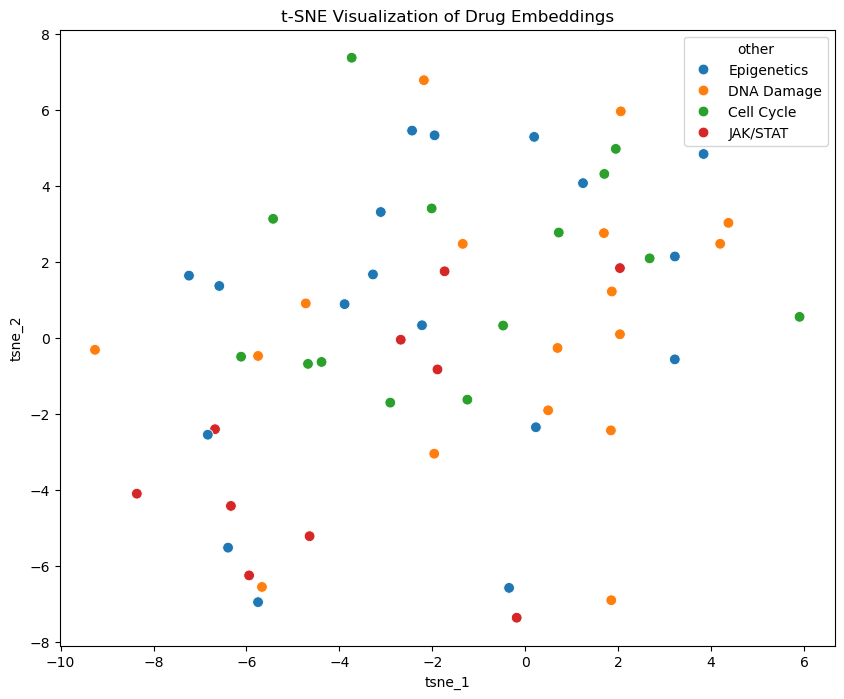

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Create a DataFrame with t-SNE results
df_tsne = pd.DataFrame(tsne_embeddings, columns=['tsne_1', 'tsne_2'])
df_tsne['other'] = df['other']

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='other', data=df_tsne, palette='tab10', s=60)
plt.title('t-SNE Visualization of Drug Embeddings')
plt.show()

In [9]:
print(embeddings.shape)

(106, 768)


## try clustering

In [ ]:
from sklearn.cluster import KMeans

# The t-SNE plots do not divide the drugs into the 4 categories as we would expect. So we can try to use a clustering algorithm to see if we can find the 4 categories from the embeddings.

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

# Add the cluster labels to the t-SNE DataFrame
df_tsne['cluster'] = kmeans_labels

# Plot the t-SNE result with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=df_tsne, palette='tab10', s=60)
plt.title('t-SNE Visualization of Drug Embeddings with KMeans Clusters')
plt.show()